In [13]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit_surface_area_pro as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [14]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 0.01, 900]


times = np.linspace(50, 90, 41)

df = pd.read_csv('2017-03-16_PRO_multi_well_inference_input_multi_well_t_50.csv', header=None)
org_values = np.transpose(df.to_numpy())
org_values = org_values[:41,:]


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((41,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [15]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [16]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 3
New dimension: 7


Create uniform log prior

In [17]:

# Define the size of the list
size = 7
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 0.00001
prior_arr_upper[1] = 0.1
prior_arr_lower[2] = 1
prior_arr_upper[2] = 4000
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100
prior_arr_lower[6] = 0
prior_arr_upper[6] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_88274/3449605926.py:29: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [18]:

xs = [
    np.array(true_parameters) * 0.7,
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.0,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 5, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       1:28.0
1     480    13:09.2
2     939    13:10.8
3     1416   13:12.1
20    8310   13:33.5
40    15615  13:52.8
60    23121  14:10.9


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated convergence failures (perhaps bad Jacobian or tolerances). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.4730863083259D-10
80    29553  14:25.6
100   35700  14:40.1
120   41685  14:53.8
140   47994  15:08.2
160   53886  15:20.9
180   59373  15:32.5
200   64824  15:44.3
220   70545  15:56.9
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.2810383717432D-12
240   75975  16:09.0
260   81594  16:20.9
280   87060  16:32.1
300   92436  16:43.6
320   98025  16:55.3
340   103230  17:06.1
360   108396  17:16.7
380   113673  17:28.0
400   119010  17:39.7
420   124860  17:51.7
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =

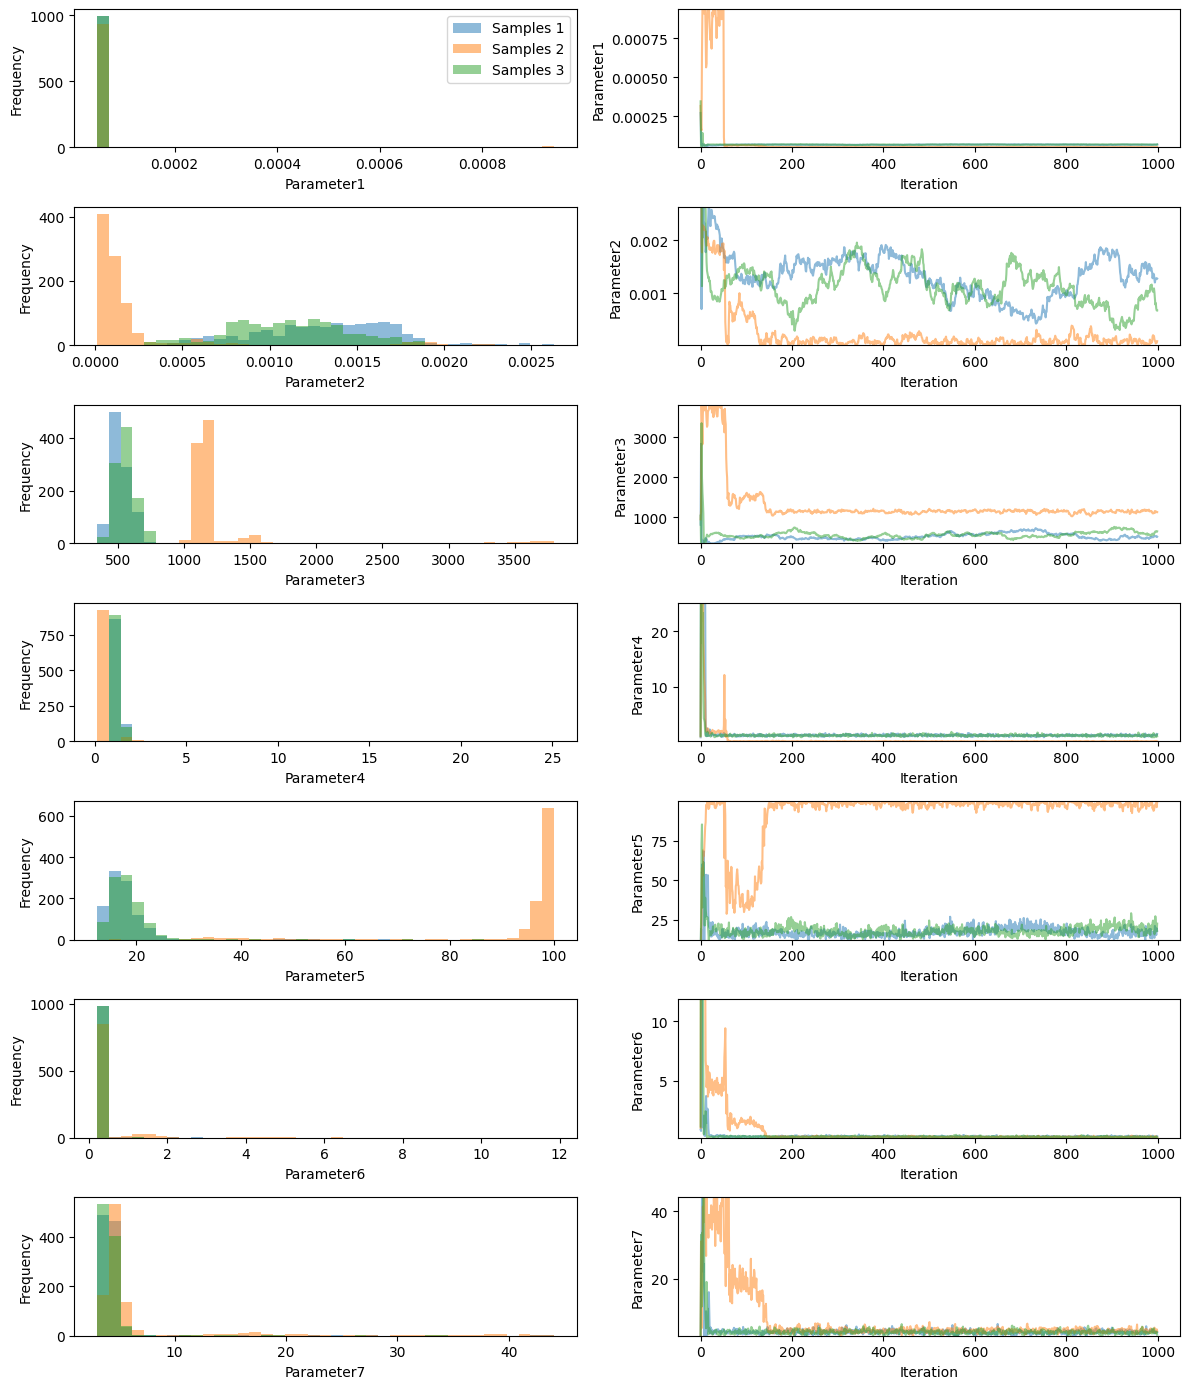

In [19]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [20]:

y0 = np.array([0.0003, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 1100,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.01, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 0.001, 500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5978603058557D-09


/Users/nathan/Documents/Oxford/DPhil/clusters/homogeneous_3D/pints_smol_moments_4_normalised_jit_surface_area_pro.py:141: RuntimeWarning: invalid value encountered in divide
  out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
/Users/nathan/Documents/Oxford/DPhil/clusters/homogeneous_3D/pints_smol_moments_4_normalised_jit_surface_area_pro.py:142: RuntimeWarning: invalid value encountered in divide
  out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)


 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.3933671832084D-12
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.8713929985313D-18
Estimated parameters:
[6.57775377e-05 1.38313818e-03 4.96259015e+02 1.20906858e+00
 1.58091424e+01 2.95720914e-01 4.05104266e+00]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pints/_optimisers/_xnes.py:82: UserWarning: All points requested by XNES are outside the boundaries.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


 lsoda--  at t(=r1) and step size h(=r2), the error  
       test failed repeatedly or with abs(h) = hmin  
      in above,  r1 =  0.8829823044057D+02   r2 =  0.2959705395267D-10
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.5480676516610D-11
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.6725490055260D-11
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+02   r2 =  0.1440281465221D-11
 lsoda--  at t (=r1) and step size h (=r2), the      
       corrector convergence failed repeatedly       
       or with abs(h) = hmin     
      in above,  r1 =  0.5000000000000D+

In [21]:
print(log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00]))

AIC = 2*7 - 2*log_likelihood([1.91275899e-04, 3.11720293e-03, 8.53718500e+02, 3.44273769e-01,
 9.26853687e+00, 6.38190763e-01, 4.52314371e+00])

print(AIC)

-9110.973250463205
18235.94650092641


In [22]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(900, 7)
[6.62116859e-05 1.26079260e-03 5.25367639e+02 1.26318127e+00
 1.70391328e+01 2.89300781e-01 4.70541393e+00]
[[6.62116859e-05 1.26079260e-03 5.25367639e+02 ... 1.70391328e+01
  2.89300781e-01 4.70541393e+00]
 [6.61095594e-05 1.32214662e-03 5.02647042e+02 ... 1.43985310e+01
  2.84617780e-01 3.60146374e+00]
 [6.68541321e-05 1.27618797e-03 5.07148974e+02 ... 1.88751148e+01
  2.86997528e-01 4.17374414e+00]
 ...
 [6.54268955e-05 1.28296273e-03 5.13518732e+02 ... 1.53610220e+01
  3.14545277e-01 4.14495021e+00]
 [6.53679858e-05 1.28119800e-03 5.22105242e+02 ... 1.95325225e+01
  2.84762401e-01 4.34649937e+00]
 [6.69804329e-05 1.27563094e-03 5.10525833e+02 ... 1.79860541e+01
  3.38776365e-01 4.07557809e+00]]


In [23]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


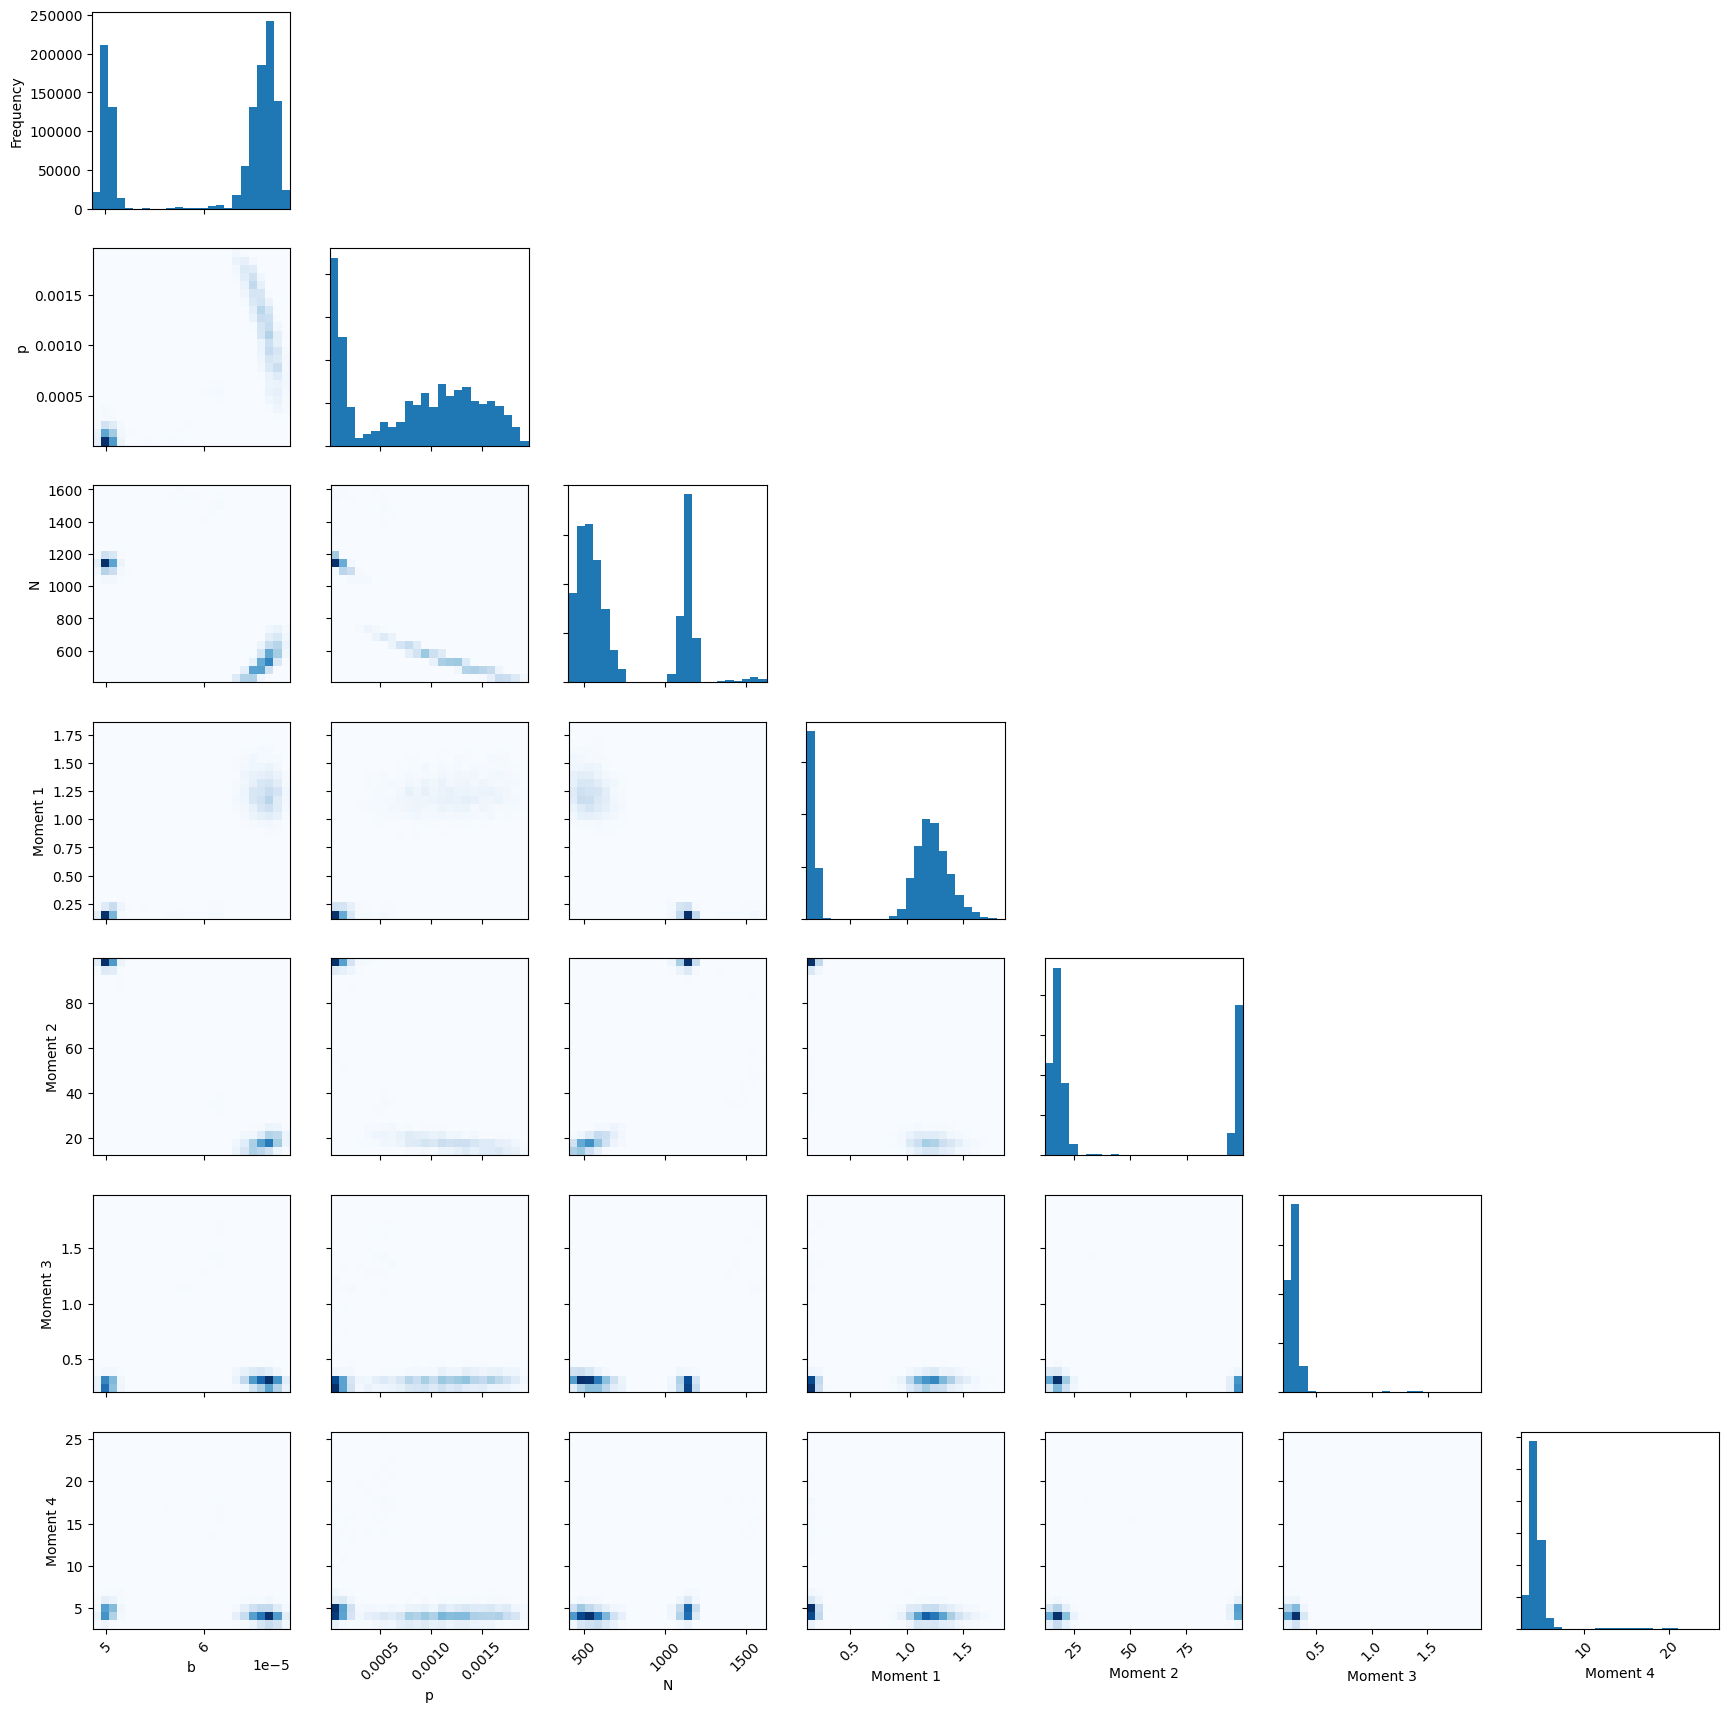

In [24]:


parameter_names = ["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p", "N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

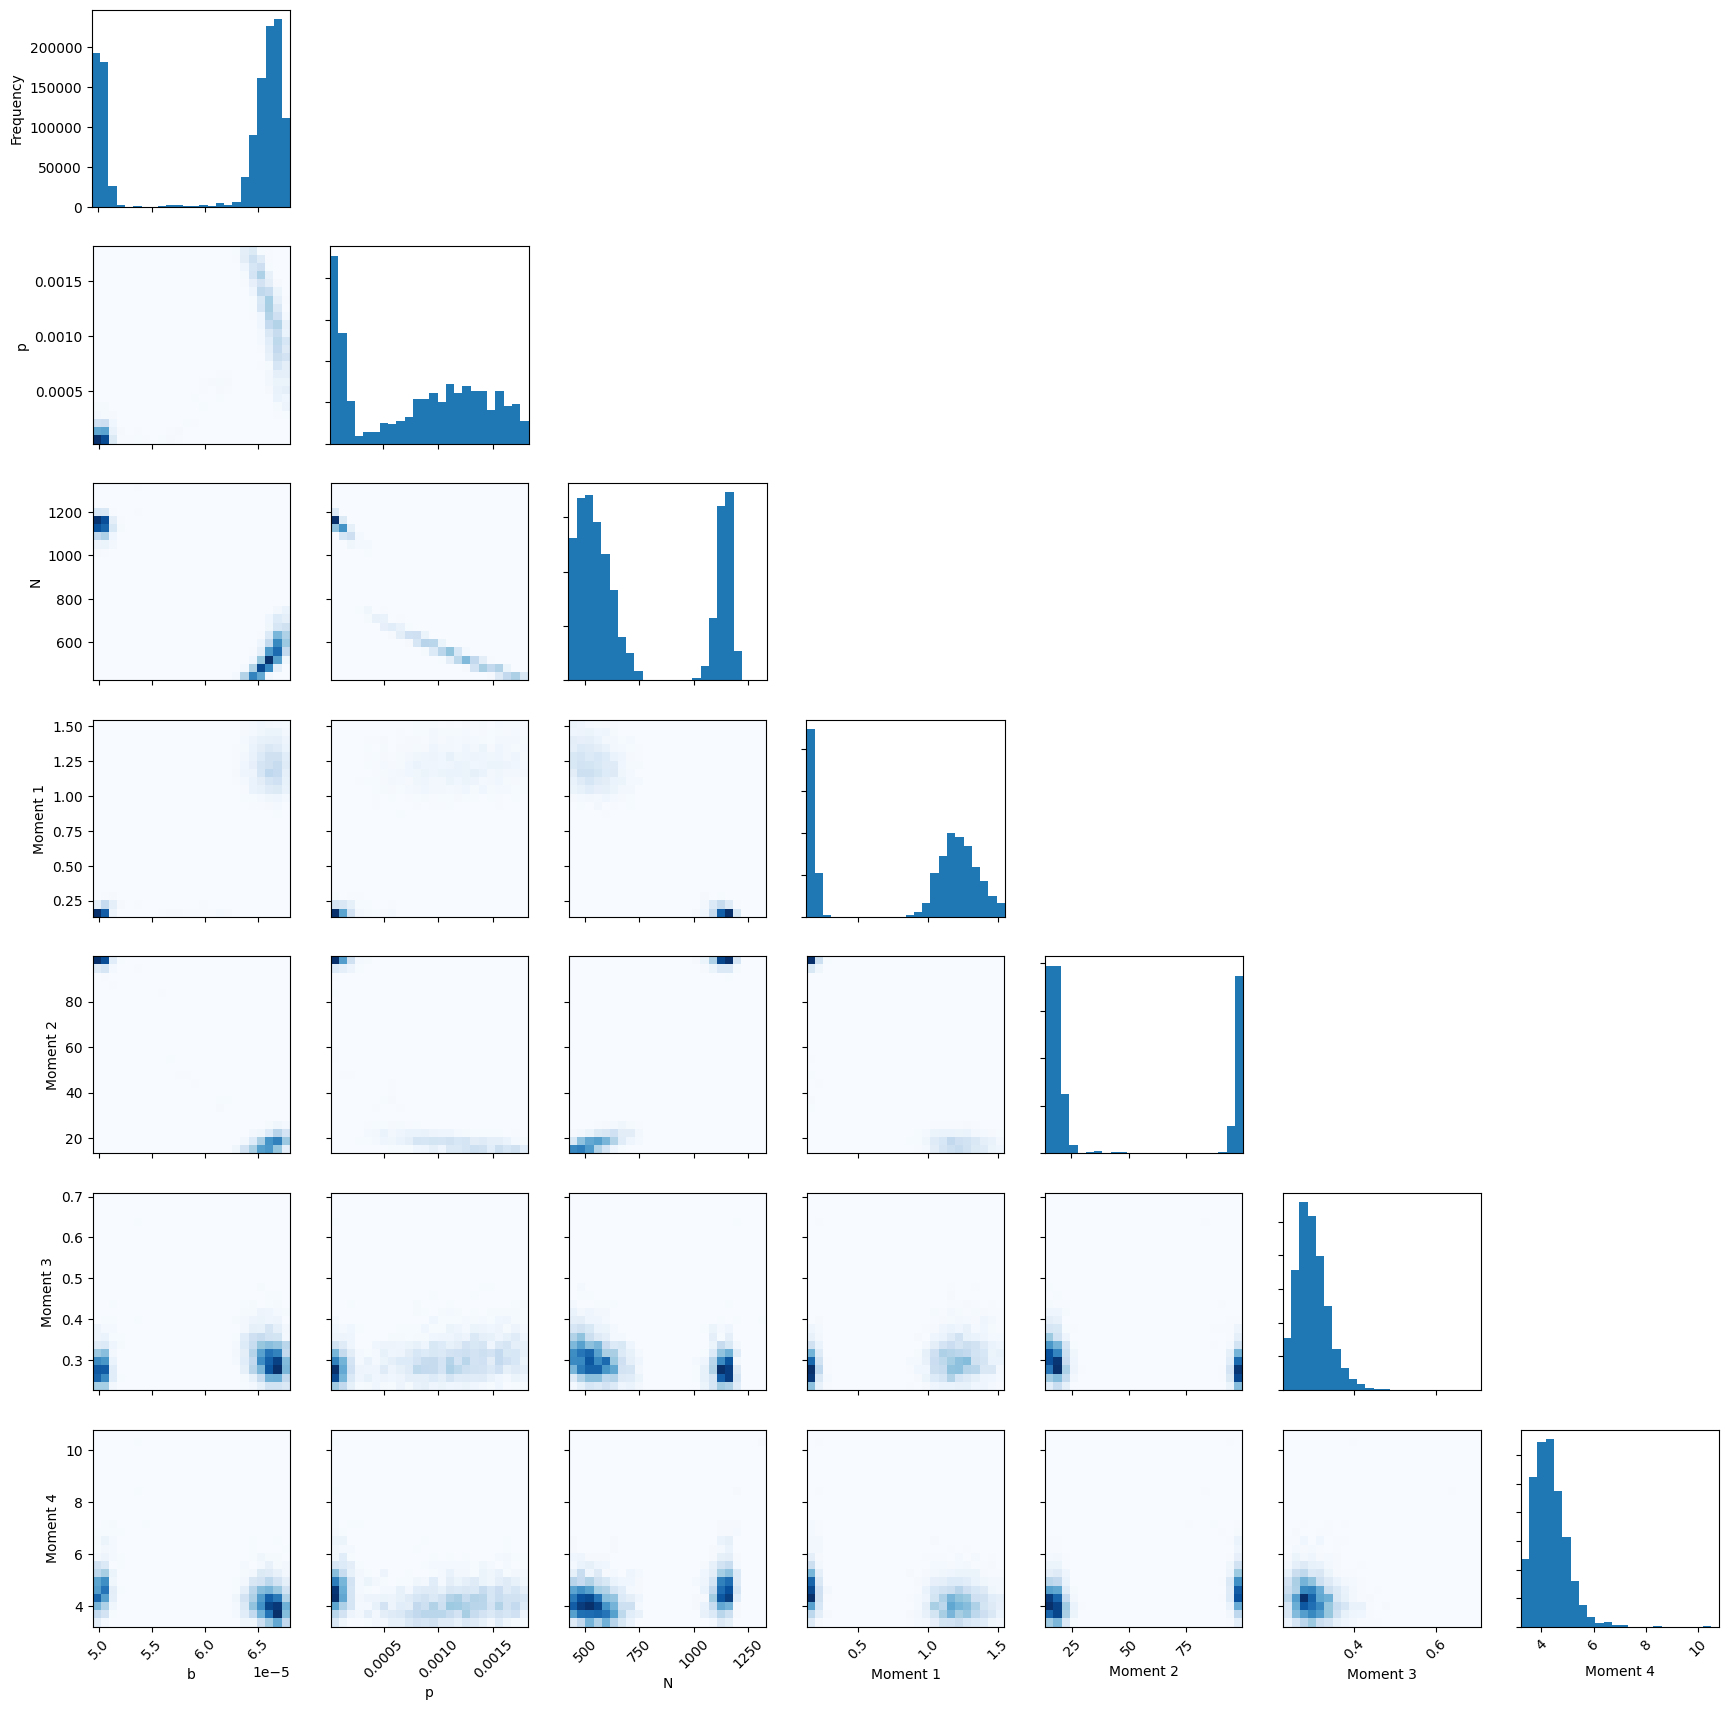

In [25]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

[6.62116859e-05 1.26079260e-03 5.25367639e+02 1.26318127e+00
 1.70391328e+01 2.89300781e-01 4.70541393e+00]


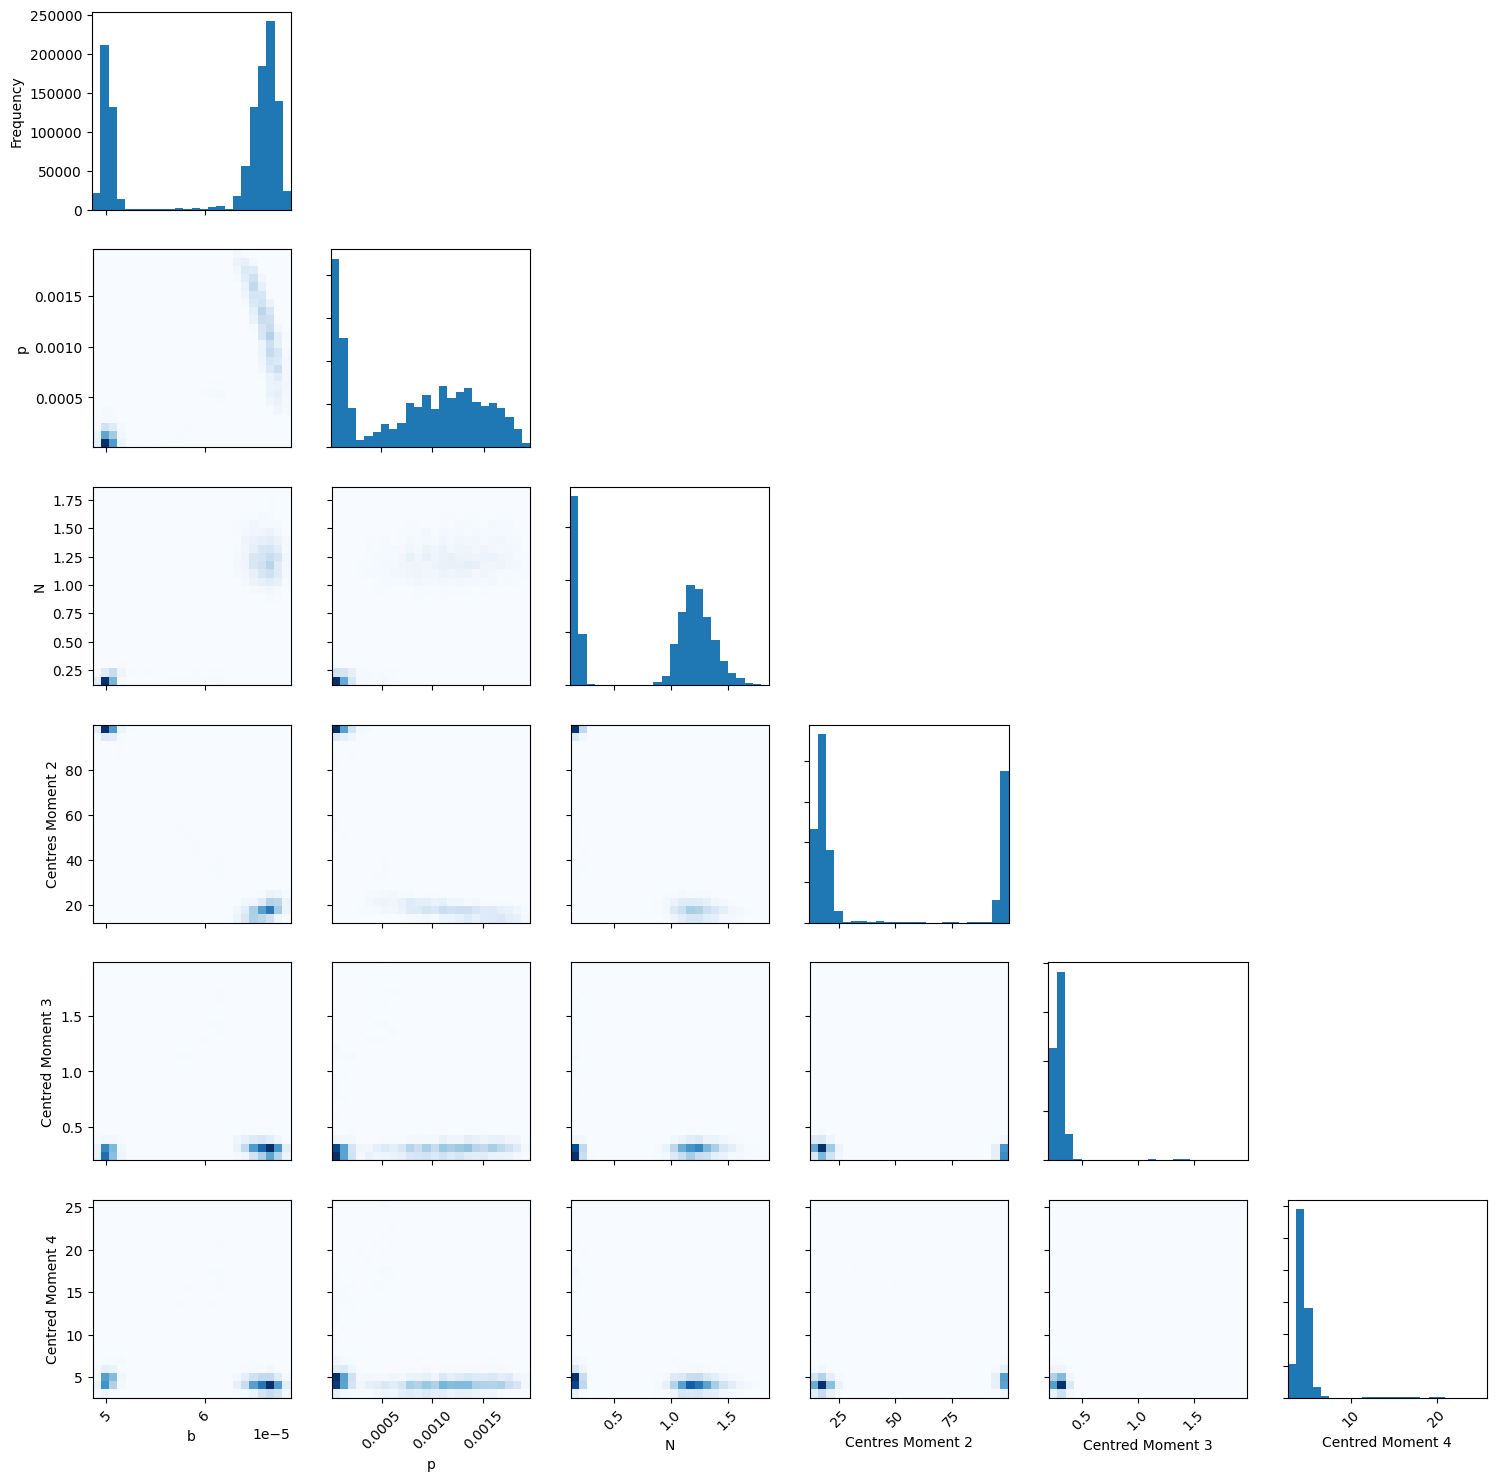

In [26]:
parameter_names = ["b","p","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5,6]], heatmap=True, 
                    parameter_names=["b","p","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [27]:
parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%      97.5%    rhat    ess     ess per sec.
--------  ------  ------  ------  ------  ------  -------  -------  ------  ------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00     0.00     11.75   136.75  0.10
p         0.00    0.00    0.00    0.00    0.00    0.00     0.00     2.55    53.64   0.04
N         758.92  276.74  440.62  545.19  616.23  1122.74  1182.44  6.06    54.35   0.04
Moment 1  0.87    0.51    0.14    0.19    1.12    1.26     1.48     4.82    378.26  0.27
Moment 2  44.96   37.80   14.16   17.21   20.10   97.55    99.84    18.56   121.41  0.09
Moment 3  0.29    0.04    0.23    0.27    0.29    0.31     0.38     1.06    382.21  0.27
Moment 4  4.26    0.60    3.27    3.81    4.20    4.65     5.52     1.12    344.89  0.24


In [28]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [29]:

parameter_names = ["b","p","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%       50%       75%       97.5%     rhat    ess    ess per sec.
--------  --------  --------  --------  --------  --------  --------  --------  ------  -----  --------------
b         6.1e-05   7.74e-06  4.95e-05  5.05e-05  6.6e-05   6.69e-05  6.79e-05  11.7    137    0.096
p         0.000725  0.000527  1.93e-05  0.000124  0.000801  0.00113   0.00172   2.55    53.6   0.0377
N         759       277       441       545       616       1.12e+03  1.18e+03  6.06    54.4   0.0381
Moment 1  0.874     0.511     0.139     0.185     1.12      1.26      1.48      4.82    378    0.265
Moment 2  45        37.8      14.2      17.2      20.1      97.5      99.8      18.6    121    0.0852
Moment 3  0.293     0.0378    0.229     0.268     0.288     0.314     0.381     1.06    382    0.268
Moment 4  4.26      0.603     3.27      3.81      4.2       4.65      5.52      1.12    345    0.242


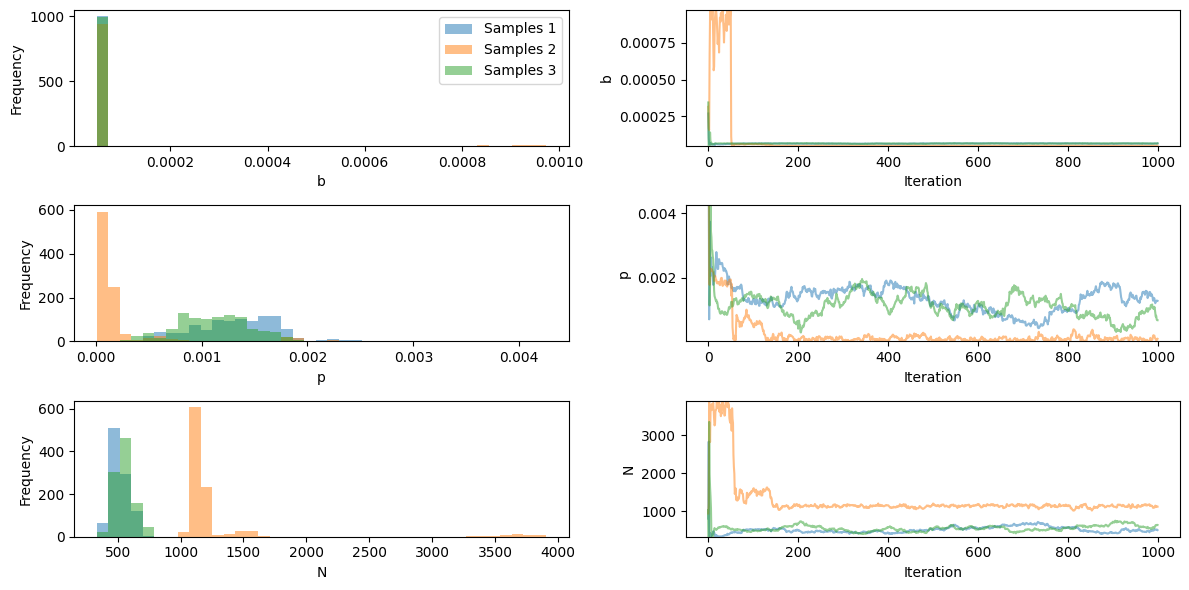

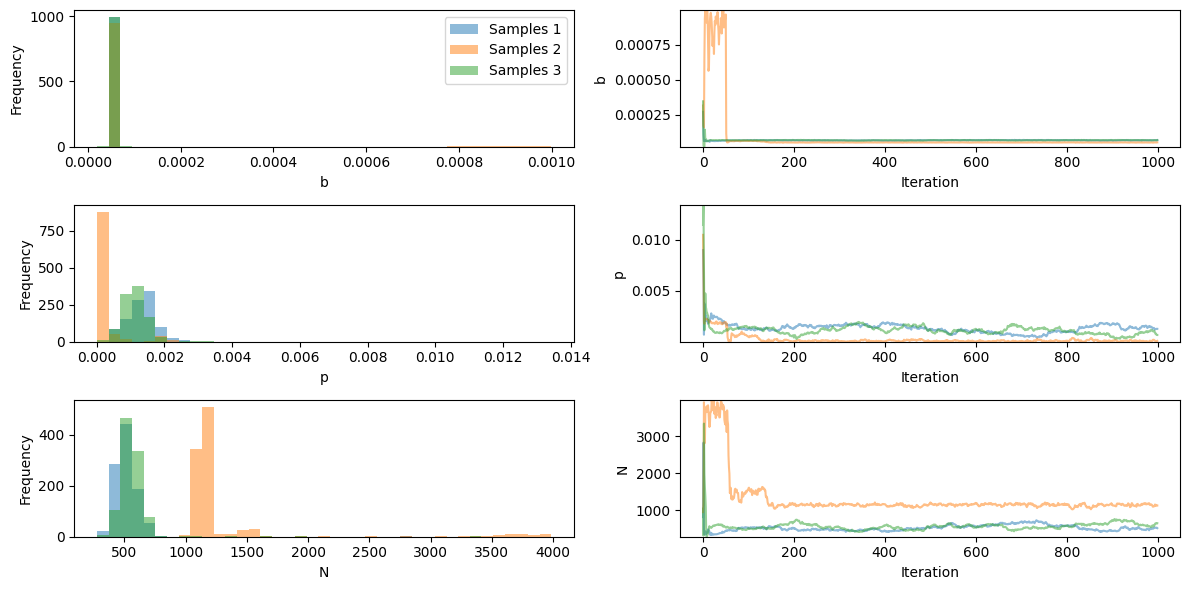

In [30]:
pints.plot.trace(chains[:,:,[0,1,2]], n_percentiles=99.5, parameter_names=["b","p","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1,2]], parameter_names=["b","p","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

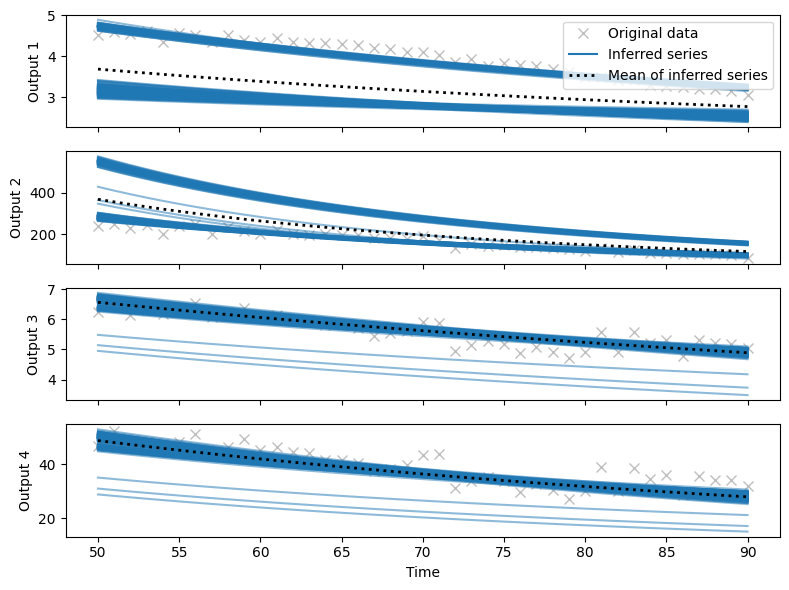

In [31]:
fig, axes = pints.plot.series(AllChains, problem)

# # Customise the plot, and add the original, noise-free data
# fig.set_size_inches(12,4.5)
# plt.plot(times, org_values, c='orange', label='Noise-free data')
# plt.legend()
# plt.show()

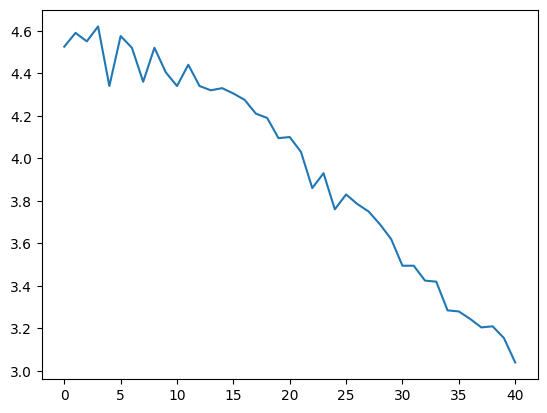

In [32]:

data_mean = out_array[:,0]
data_variance = out_array[:,1]
data_skewness = out_array[:,2]
data_kurtosis = out_array[:,3]

# for i in range(1000):

plt.plot(data_mean)